$V(x)=\sum_{t=1}^T R(x(t))$ \
where  $R(x)=-\|x-x_{goal}\|-variance$ \
and $T=15$

Use all datas 

# Create Environment

In [1]:
import numpy as np
import matplotlib.pylab as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from tqdm import tqdm

global N

N=50

global M
M=10

global T
global target
T=15
target=np.array([3,2])
global w
w=np.pi*2/23.7

global delta_t
delta_t=T/N

global obs_para
obs_para=6

global beta
beta=[0.95,0.975,1,1.025,1.05]

global num_system
num_system=5

global num_action
num_action=8

global coeff
coeff=[]
for i in range(N+1):
    coeff.append(0.1**(N-i))
print(coeff)

C:\Users\ChangWeiYueh\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[1.0000000000000027e-50, 1.0000000000000028e-49, 1.0000000000000027e-48, 1.0000000000000026e-47, 1.0000000000000026e-46, 1.0000000000000025e-45, 1.0000000000000024e-44, 1.0000000000000025e-43, 1.0000000000000023e-42, 1.0000000000000023e-41, 1.0000000000000022e-40, 1.0000000000000022e-39, 1.000000000000002e-38, 1.0000000000000022e-37, 1.000000000000002e-36, 1.0000000000000019e-35, 1.0000000000000019e-34, 1.0000000000000018e-33, 1.0000000000000018e-32, 1.0000000000000016e-31, 1.0000000000000017e-30, 1.0000000000000016e-29, 1.0000000000000015e-28, 1.0000000000000015e-27, 1.0000000000000015e-26, 1.0000000000000014e-25, 1.0000000000000014e-24, 1.0000000000000013e-23, 1.0000000000000012e-22, 1.0000000000000012e-21, 1.0000000000000011e-20, 1.000000000000001e-19, 1.000000000000001e-18, 1.000000000000001e-17, 1.0000000000000008e-16, 1.0000000000000009e-15, 1.0000000000000008e-14, 1.0000000000000007e-13, 1.0000000000000006e-12, 1.0000000000000006e-11, 1.0000000000000006e-10, 1.0000000000000005e-

In [2]:
def Z(vecs, u, v):
    output=[]
    for i in range(num_system):
        vec=vecs[i]
        x=vec[0]
        y=vec[1]
        theta=vec[2]
        output.append([beta[i]*np.cos(theta)*u,beta[i]*np.sin(theta)*u,beta[i]*v])
    return np.array(output)

#check the correctness of Z
'''
x = np.linspace(0, 6.5, 1001)
plt.plot(x, Z(x))
plt.xlabel('Angle [rad]')
plt.ylabel('Z(theta)')
plt.grid()
plt.show()
'''

"\nx = np.linspace(0, 6.5, 1001)\nplt.plot(x, Z(x))\nplt.xlabel('Angle [rad]')\nplt.ylabel('Z(theta)')\nplt.grid()\nplt.show()\n"

In [3]:
def next_step(vecs,action):  
    u=action[0]
    v=action[1]
   
    for j in range(M):
        vecs_new=[]
        diff=Z(vecs,u,v)
        for i in range(num_system):
            w=vecs[i]+delta_t/M*diff[i]
            '''
            if w[2]>np.pi:
                w[2]-=2*np.pi
            if w[2]<-np.pi:
                w[2]+=2*np.pi
            '''
            vecs_new.append(w)
        vecs=np.array(vecs_new)
    return vecs

def observe(vecs):
    mu_x=0
    mu_y=0
    mu_theta=0
    var_x=0
    var_y=0
    var_theta=0
    for i in range(num_system):
        mu_x+=vecs[i][0]
        mu_y+=vecs[i][1]
        mu_theta+=vecs[i][2]
        var_x+=vecs[i][0]**2
        var_y+=vecs[i][1]**2
        var_theta+=vecs[i][2]**2
    var_x-=mu_x**2/num_system
    var_y-=mu_y**2/num_system
    var_theta-=mu_theta**2/num_system
    
    w=np.array([mu_x,mu_y,mu_theta,var_x,var_y,var_theta])/num_system
    if w[2]>np.pi:
        w[2]-=2*np.pi
    if w[2]<-np.pi:
        w[2]+=2*np.pi
    return w

def reward(obs):
    return max(7-max(abs(obs[0]-target[0]),abs(obs[1]-target[1]))-10*obs[3]-10*obs[4],0)

def reward_raw(position):
    r=0
    for i in range(num_system):
        r+=np.linalg.norm(position[i,[0,1]]-target)
    return r

def value_func(funcs,flags,next_state):
    result=[]
    for i in range(num_action):
        if flags[i]:
            result.append(0)
        else:
            k,_=funcs[i].predict(next_state.reshape(-1,obs_para), return_std=True)
            result.append(k[0])
    result=np.array(result)
    return np.max(result)

# Learning Settings

In [4]:
global lr
lr=0.01
global eps
eps=0.2
global max_u
max_u=2
global precision
precision=0.0002
global action_set
action_set=np.array([[1,np.pi/2],[-1,np.pi/2],[1,np.pi/4],[-1,np.pi/4],[1,0],[-1,0],[1,-np.pi/4],[-1,-np.pi/4],[1,-np.pi/2],[-1,-np.pi/2]])

def exploration():
    a=np.random.uniform()
    if a<eps:
        return True
    else:
        return False

def find_max(cand):
    return np.argmax(cand)
    
def decide_u(funcs,flags,state,init=False):
    explo=exploration()
    if init or explo:
        return np.random.randint(num_action)
    else:
        result=[]
        for i in range(num_action):
            if flags[i]:
                return i
            else:
                k,_=funcs[i].predict(state.reshape(-1,obs_para), return_std=True)
                result.append(k[0])
    result=np.array(result)
    return np.argmax(result)
    
def decide_u_exploitation(funcs,flags,state,init=False):
    result=[]
    for i in range(num_action):
        if flags[i]:
            print("Err",i)
            return i
        else:
            k,_=funcs[i].predict(state.reshape(-1,obs_para), return_std=True)
            result.append(k[0])
    result=np.array(result)
    return np.argmax(result)

history_su=[0 for i in range(num_action)]
history_r=[0 for i in range(num_action)]
history_su_next=[0 for i in range(num_action)]
flags=[True for i in range(num_action)]

history_rt=[[[] for i in range(num_action)] for j in range(N+1)]
history_sut=[[[] for i in range(num_action)] for j in range(N+1)]
flags_t=[[True for i in range(num_action)] for j in range(N+1)]

# Simulation


In [5]:
num_iter=80

position_result=[]
observation_result=[]
gpr_list=[[0 for i in range(num_action)] for j in range(N+1)]

best_r=-10000
best_obs=[]
best_pos=[[] for i in range(num_system)]
best_u=[]

for iterr in tqdm(range(num_iter)):
    #initialize
    position=np.array([[-2,-2,0] for _ in range(num_system)])
    observation=observe(position)
    u_t=[]
    r_t=[]
    observation_t=[observation]
    position_t=[[] for i in range(num_system)]
    
    
    history_target=[0 for i in range(num_action)]
    
    '''
    coeff=[]
    for i in range(N):
        coeff.append((np.random.random()-0.5)/100+0.8**(N-i))
    coeff.append(1)
    #print(coeff)
    '''
    
    for time in range(N+1):
        if iterr<5:
            #candidates_u=[]
            u_k = decide_u(gpr_list[time],flags,observation,init=True)
            position_new = next_step(position,action_set[u_k])
            observation_new = observe(position_new)
            r = reward(observation_new)
            r_t.append(r)
            
            if flags[u_k]:
                history_su[u_k] = observation.reshape(-1,obs_para)
                history_su_next[u_k] = observation_new.reshape(-1,obs_para)  
                history_r[u_k] = np.array([r])
                flags[u_k]=False
            else:
                history_su[u_k] = np.concatenate((history_su[u_k], observation.reshape(-1,obs_para)))
                history_su_next[u_k] = np.concatenate((history_su_next[u_k], observation_new.reshape(-1,obs_para)))
                history_r[u_k] = np.concatenate((history_r[u_k],np.array([r])))
            
            
            observation=observation_new
            position=position_new
            u_t.append(u_k)
            observation_t.append(observation)
            for i in range(num_system):
                position_t[i].append(position[i])
            
            
        else:
            #candidates_u=[]
            u_k = decide_u(gpr_list[time],flags,observation)
            #print(candidates_u)
            #u_k, explo = decide_u(observation,np.array(candidates_u))
            
            position_new = next_step(position,action_set[u_k])
            observation_new = observe(position_new)
            r = reward(observation_new)
            r_t.append(r)
            
            history_su[u_k] = np.concatenate((history_su[u_k], observation.reshape(-1,obs_para)))
            history_r[u_k] = np.concatenate((history_r[u_k],np.array([r])))
            history_su_next[u_k] = np.concatenate((history_su_next[u_k], observation_new.reshape(-1,obs_para)))
            
            observation=observation_new
            position=position_new
            u_t.append(u_k)
            observation_t.append(observation)
            for i in range(num_system):
                position_t[i].append(position[i])
            
            
            
            
    #update
    #calculate cumulative r 
    

    '''
    for j in range(6):
        history_target[j]=last_coeff*history_r[u_t[-i]]
        gpr_list[-i][j]=GaussianProcessRegressor(alpha=1e-4).fit(history_su[j], history_target[j])
    '''  
         
    #TODO
       
    for i in range(N+1):
        if i==1:
            for j in range(num_action):
                history_target[j]=coeff[-1]*history_r[j]
                gpr_list[-i][j]=GaussianProcessRegressor(alpha=1e-5).fit(np.array(history_su[j]).reshape(-1,obs_para), history_target[j].reshape(-1,1))
            
        elif i>1:
            for j in range(num_action):
                history_tar=[]
                for k in range(history_r[j].shape[0]):
                    history_tar.append(coeff[N+1-i]*history_r[j][k]+value_func(gpr_list[-i+1],flags_t[-i+1],history_su_next[j][k]))
                gpr_list[-i][j]=GaussianProcessRegressor(alpha=1e-5).fit(np.array(history_su[j]).reshape(-1,obs_para), np.array(history_tar).reshape(-1,1))
            '''
            r_t[-i]=0.5**(N+1-i)*r_t[-i]+value_func(gpr_list[-i+1],flags_t[-i+1],observation_t[-i+1])
            history_rt[-i][u_t[-i]].append(r_t[-i])
            history_sut[-i][u_t[-i]].append(observation_t[-i])
            gpr_list[-i][u_t[-i]]=GaussianProcessRegressor(alpha=1e-4).fit(np.array(history_sut[-i][u_t[-i]]).reshape(-1,5), np.array(history_rt[-i][u_t[-i]]).reshape(-1,1))
            if flags_t[-i][u_t[-i]]:
                flags_t[-i][u_t[-i]]=False
            '''
    for j in range(num_action):
        history_tar=[]
        for k in range(history_r[j].shape[0]):
            history_tar.append(coeff[0]*history_r[j][k]+value_func(gpr_list[1],flags_t[1],history_su_next[j][k]))
        gpr_list[0][j]=GaussianProcessRegressor(alpha=1e-5).fit(np.array(history_su[j]).reshape(-1,obs_para), np.array(history_tar).reshape(-1,1))

            
        
    print("observation =",observation)
    #print(observation_t)
    position_result.append(position)
    observation_result.append(observation)
    if r>best_r:
        best_r=r
        best_obs=observation_t
        best_pos=position_t
        best_u=u_t
    
    #print(history_su.shape)
    #print(u_t)

  1%|█                                                                                  | 1/80 [00:01<01:24,  1.07s/it]

observation = [ 1.30528176 -4.85919777 -2.27765467  0.09333127  0.07780016  0.02005534]


  2%|██                                                                                 | 2/80 [00:01<01:13,  1.07it/s]

observation = [-5.95081715e-01 -3.56729673e+00  2.35619449e+00  1.01605071e-02
  3.06896580e-03  6.93956559e-03]


  4%|███                                                                                | 3/80 [00:02<01:11,  1.08it/s]

observation = [-2.56437785 -4.07886098 -1.80641578  0.0285969   0.01439637  0.02505183]


  5%|████▏                                                                              | 4/80 [00:03<01:13,  1.03it/s]

observation = [-4.20390532 -1.19607073 -2.74889357  0.02712575  0.02033371  0.01561402]


  6%|█████▏                                                                             | 5/80 [00:04<01:16,  1.02s/it]

observation = [-3.61303187 -1.57626687 -0.39269908  0.00821019  0.00785484  0.04337228]


  8%|██████▏                                                                            | 6/80 [00:06<01:18,  1.07s/it]

observation = [ 0.12607925 -0.34895628 -2.04203522  0.00483524  0.01163293  0.02248419]


  9%|███████▎                                                                           | 7/80 [00:07<01:24,  1.15s/it]

observation = [ 5.43571259e-01 -7.50282170e-01 -2.51327412e+00  6.16173162e-04
  6.16135004e-02  1.77652879e-02]


 10%|████████▎                                                                          | 8/80 [00:08<01:29,  1.24s/it]

observation = [-0.25899859 -1.04044868  1.72787596  0.01658764  0.00504546  0.08022138]


 11%|█████████▎                                                                         | 9/80 [00:10<01:33,  1.32s/it]

observation = [ 2.27568625  1.44818632 -0.39269908  0.04220049  0.13494554  0.04337228]


 12%|██████████▎                                                                       | 10/80 [00:11<01:37,  1.39s/it]

observation = [ 1.75992649e+00  1.32587658e-01 -1.33517688e+00  8.73280226e-04
  6.24528071e-02  3.06034843e-02]


 14%|███████████▎                                                                      | 11/80 [00:13<01:39,  1.45s/it]

observation = [ 1.90617478  0.52122357 -1.57079633  0.00424985  0.117134    0.02775826]


 15%|████████████▎                                                                     | 12/80 [00:15<01:58,  1.75s/it]

observation = [ 1.38722136 -0.20495107 -2.27765467  0.00361734  0.04614495  0.02005534]


 16%|█████████████▎                                                                    | 13/80 [00:18<02:12,  1.97s/it]

observation = [ 2.50993466  0.0707038  -2.04203522  0.01345012  0.04340455  0.02248419]


 18%|██████████████▎                                                                   | 14/80 [00:21<02:23,  2.17s/it]

observation = [ 9.07625937e-02 -3.99539507e-01  2.12057504e+00  7.50054415e-04
  1.12830107e-02  5.62104813e-03]


 19%|███████████████▍                                                                  | 15/80 [00:23<02:31,  2.33s/it]

observation = [ 2.07143926e+00  1.10037762e+00 -1.33517688e+00  4.06668195e-04
  5.66217868e-02  3.06034843e-02]


 20%|████████████████▍                                                                 | 16/80 [00:26<02:33,  2.40s/it]

observation = [ 6.47489904e-01  1.61033639e+00 -1.80641578e+00  2.24290164e-03
  1.53941355e-04  2.50518318e-02]


 21%|█████████████████▍                                                                | 17/80 [00:28<02:31,  2.40s/it]

observation = [ 6.88917929e+00  1.68528719e+00 -2.98451302e+00  2.35601369e-03
  8.71893415e-01  1.36015486e-02]


 22%|██████████████████▍                                                               | 18/80 [00:31<02:44,  2.66s/it]

observation = [ 2.80252786  0.36627332 -3.06305284  0.03975769  0.00529681  0.01172787]


 24%|███████████████████▍                                                              | 19/80 [00:35<02:58,  2.93s/it]

observation = [4.82814939 1.54455063 0.07853982 0.01385851 1.10396162 0.05058943]


 25%|████████████████████▌                                                             | 20/80 [00:39<03:05,  3.10s/it]

observation = [2.87261793e+00 2.83649653e+00 1.41371669e+00 2.78134606e-02
 4.16379840e-02 2.49824361e-03]


 26%|█████████████████████▌                                                            | 21/80 [00:42<03:12,  3.27s/it]

observation = [0.18299234 1.41846112 4.7909288  0.402843   0.1859839  0.153295  ]


 28%|██████████████████████▌                                                           | 22/80 [00:46<03:16,  3.39s/it]

observation = [ 1.06535072 -0.61821004 -2.04203522  0.00278102  0.05302913  0.02248419]


 29%|███████████████████████▌                                                          | 23/80 [00:49<03:10,  3.34s/it]

observation = [ 1.97154587  1.16418893 -0.39269908  0.00483575  0.08212497  0.04337228]


 30%|████████████████████████▌                                                         | 24/80 [00:52<02:52,  3.08s/it]

observation = [5.77025337e-01 2.87979805e-01 7.06858347e-01 1.82865337e-04
 1.57711726e-02 6.24560904e-04]


 31%|█████████████████████████▋                                                        | 25/80 [00:54<02:36,  2.84s/it]

observation = [-4.04827472e-02  1.65988001e+00 -1.09955743e+00  1.71649071e-04
  1.04493700e-02  3.35874975e-02]


 32%|██████████████████████████▋                                                       | 26/80 [00:56<02:23,  2.66s/it]

observation = [ 5.3645721  -0.87031202  2.59181394  0.06998969  0.01429535  0.00839687]


 34%|███████████████████████████▋                                                      | 27/80 [00:59<02:18,  2.61s/it]

observation = [ 1.56179694e+00  8.11453883e-01 -1.80641578e+00  1.44190166e-04
  6.63517313e-02  2.50518318e-02]


 35%|████████████████████████████▋                                                     | 28/80 [01:03<02:36,  3.01s/it]

observation = [6.52439450e+00 6.19273342e-01 2.12057504e+00 6.44180731e-02
 3.59657790e-01 5.62104813e-03]


 36%|█████████████████████████████▋                                                    | 29/80 [01:06<02:37,  3.09s/it]

observation = [ 2.08888959  1.16126952 -1.33517688  0.00360937  0.07332711  0.03060348]


 38%|██████████████████████████████▊                                                   | 30/80 [01:10<02:56,  3.52s/it]

observation = [1.72258159e+00 9.89683810e-01 4.71238898e-01 1.87023974e-03
 3.26372027e-02 2.77582624e-04]


 39%|███████████████████████████████▊                                                  | 31/80 [01:15<03:11,  3.91s/it]

observation = [ 1.82061760e+00  7.76330737e-01 -3.92699082e-01  6.04436738e-05
  5.38849781e-02  4.33722850e-02]


 40%|████████████████████████████████▊                                                 | 32/80 [01:20<03:22,  4.21s/it]

observation = [ 5.15188296e+00  2.23128682e+00 -2.51327412e+00  8.95279746e-04
  4.08237578e-01  1.77652879e-02]


 41%|█████████████████████████████████▊                                                | 33/80 [01:25<03:31,  4.50s/it]

observation = [ 1.70013542  0.73185718 -1.33517688  0.02806411  0.00550277  0.03060348]


 42%|██████████████████████████████████▊                                               | 34/80 [01:30<03:32,  4.63s/it]

observation = [ 2.3919568   1.24240004 -2.98451302  0.01087647  0.03388532  0.01360155]


 44%|███████████████████████████████████▉                                              | 35/80 [01:35<03:33,  4.74s/it]

observation = [2.77047244e+00 1.76678822e+00 1.41371669e+00 3.00874604e-03
 6.05107010e-02 2.49824361e-03]


 45%|████████████████████████████████████▉                                             | 36/80 [01:41<03:38,  4.96s/it]

observation = [ 2.31903197  1.37796397 -1.80641578  0.01032068  0.04011494  0.02505183]


 46%|█████████████████████████████████████▉                                            | 37/80 [01:47<03:45,  5.24s/it]

observation = [ 3.18145820e+00  2.04285457e+00 -2.27765467e+00  2.92233835e-04
  1.10808818e-01  2.00553446e-02]


 48%|██████████████████████████████████████▉                                           | 38/80 [01:53<03:52,  5.55s/it]

observation = [ 3.42325538 -0.8390512  -1.33517688  0.23859568  0.02937134  0.03060348]


 49%|███████████████████████████████████████▉                                          | 39/80 [02:00<04:02,  5.92s/it]

observation = [ 1.55226808  0.65128157 -2.27765467  0.00648467  0.08323257  0.02005534]


 50%|█████████████████████████████████████████                                         | 40/80 [02:06<04:02,  6.05s/it]

observation = [-0.61146763  1.2965375   3.06305284  0.01659462  0.00687728  0.01172787]


 51%|██████████████████████████████████████████                                        | 41/80 [02:13<04:02,  6.22s/it]

observation = [ 2.46362950e+00  1.88396345e+00 -2.51327412e+00  1.80611993e-03
  3.80818016e-02  1.77652879e-02]


 52%|███████████████████████████████████████████                                       | 42/80 [02:20<04:05,  6.47s/it]

observation = [ 2.93061389  1.58763355 -2.04203522  0.01567761  0.03954053  0.02248419]


 54%|████████████████████████████████████████████                                      | 43/80 [02:26<04:03,  6.57s/it]

observation = [3.20425017e+00 1.88034347e+00 7.06858347e-01 5.34020218e-03
 5.72968473e-02 6.24560904e-04]


 55%|█████████████████████████████████████████████                                     | 44/80 [02:34<04:06,  6.84s/it]

observation = [2.35980218e+00 1.97344663e+00 1.88495559e+00 9.10182018e-04
 5.64145219e-02 4.44132198e-03]


 56%|██████████████████████████████████████████████▏                                   | 45/80 [02:42<04:11,  7.17s/it]

observation = [2.76142222e+00 1.64679940e+00 7.06858347e-01 4.70894075e-03
 5.09407333e-02 6.24560904e-04]


 57%|███████████████████████████████████████████████▏                                  | 46/80 [02:50<04:11,  7.39s/it]

observation = [ 3.09956229  2.22566451 -1.57079633  0.00315265  0.0717871   0.02775826]


 59%|████████████████████████████████████████████████▏                                 | 47/80 [02:58<04:10,  7.60s/it]

observation = [ 2.73146176e+00  2.46121372e+00 -2.98451302e+00  2.42830479e-04
  5.32438045e-02  1.36015486e-02]


 60%|█████████████████████████████████████████████████▏                                | 48/80 [03:06<04:12,  7.89s/it]

observation = [2.57148223e+00 2.18601948e+00 3.06305284e+00 3.26530223e-04
 3.89417674e-02 1.17278659e-02]


 61%|██████████████████████████████████████████████████▏                               | 49/80 [03:15<04:09,  8.05s/it]

observation = [ 0.12234814  1.4737791  -1.33517688  0.02807656  0.10297575  0.03060348]


 62%|███████████████████████████████████████████████████▎                              | 50/80 [03:24<04:10,  8.36s/it]

observation = [ 2.82816372e+00  1.95247875e+00 -2.74889357e+00  3.85765745e-04
  5.41719409e-02  1.56140226e-02]


 64%|████████████████████████████████████████████████████▎                             | 51/80 [03:33<04:12,  8.71s/it]

observation = [2.65039356e+00 2.72152032e+00 3.06305284e+00 9.84749954e-04
 5.49781230e-02 1.17278659e-02]


 65%|█████████████████████████████████████████████████████▎                            | 52/80 [03:43<04:14,  9.10s/it]

observation = [3.04445417e+00 1.86866286e+00 9.42477796e-01 3.48397691e-03
 5.37623316e-02 1.11033050e-03]


 66%|██████████████████████████████████████████████████████▎                           | 53/80 [03:54<04:17,  9.55s/it]

observation = [ 2.72997014e+00  1.87594724e+00 -2.98451302e+00  2.29467907e-03
  6.34089525e-02  1.36015486e-02]


 68%|███████████████████████████████████████████████████████▎                          | 54/80 [04:05<04:18,  9.95s/it]

observation = [2.76464680e+00 1.74676491e+00 4.71238898e-01 4.52444266e-03
 5.51483622e-02 2.77582624e-04]


 69%|████████████████████████████████████████████████████████▍                         | 55/80 [04:17<04:21, 10.44s/it]

observation = [ 2.94785756e+00  1.80872554e+00 -1.33517688e+00  1.86031005e-04
  1.13755104e-01  3.06034843e-02]


 70%|█████████████████████████████████████████████████████████▍                        | 56/80 [04:29<04:25, 11.06s/it]

observation = [ 2.53083856  3.98065026 -2.98451302  0.01696379  0.1313988   0.01360155]


 71%|██████████████████████████████████████████████████████████▍                       | 57/80 [04:42<04:26, 11.61s/it]

observation = [2.72117527e+00 1.92192966e+00 1.17809725e+00 3.12237754e-03
 6.33080708e-02 1.73489140e-03]


 72%|███████████████████████████████████████████████████████████▍                      | 58/80 [04:54<04:19, 11.82s/it]

observation = [3.06853282 2.13028298 1.64933614 0.00334421 0.06554712 0.00340039]


 74%|████████████████████████████████████████████████████████████▍                     | 59/80 [05:07<04:17, 12.26s/it]

observation = [2.92701475e+00 2.13138486e+00 2.82743339e+00 2.13965141e-03
 6.10761263e-02 9.99297446e-03]


 75%|█████████████████████████████████████████████████████████████▌                    | 60/80 [05:21<04:14, 12.71s/it]

observation = [2.79637725e+00 2.39087413e+00 1.41371669e+00 9.65832837e-04
 7.11125783e-02 2.49824361e-03]


 76%|██████████████████████████████████████████████████████████████▌                   | 61/80 [05:35<04:06, 12.96s/it]

observation = [3.11121904 2.0710531  1.64933614 0.00383214 0.06401917 0.00340039]


 78%|███████████████████████████████████████████████████████████████▌                  | 62/80 [05:49<04:02, 13.46s/it]

observation = [ 5.07757788e-01 -6.31936025e-01  3.06305284e+00  1.82836245e-03
  1.08377074e-02  1.17278659e-02]


 79%|████████████████████████████████████████████████████████████████▌                 | 63/80 [06:05<03:59, 14.10s/it]

observation = [1.43357393e+00 1.79428179e+00 4.71238898e-01 3.44535417e-04
 4.29006362e-02 2.77582624e-04]


 80%|█████████████████████████████████████████████████████████████████▌                | 64/80 [06:21<03:54, 14.64s/it]

observation = [ 3.13383466e+00  1.99558348e+00 -7.06858347e-01  3.60241885e-03
  6.39751354e-02  6.24560904e-04]


 81%|██████████████████████████████████████████████████████████████████▋               | 65/80 [06:37<03:45, 15.06s/it]

observation = [2.94760762e+00 2.22813987e+00 2.82743339e+00 2.00035265e-03
 6.64199785e-02 9.99297446e-03]


 82%|███████████████████████████████████████████████████████████████████▋              | 66/80 [06:53<03:35, 15.41s/it]

observation = [2.59906894e+00 1.66446686e+00 3.06305284e+00 2.10787540e-03
 3.87313121e-02 1.17278659e-02]


 84%|████████████████████████████████████████████████████████████████████▋             | 67/80 [07:10<03:24, 15.74s/it]

observation = [2.92105120e+00 2.21867663e+00 1.41371669e+00 2.08183723e-03
 6.56145773e-02 2.49824361e-03]


 85%|█████████████████████████████████████████████████████████████████████▋            | 68/80 [07:27<03:13, 16.16s/it]

observation = [2.97367972e+00 1.98722595e+00 1.41371669e+00 2.63369943e-03
 5.73038249e-02 2.49824361e-03]


 86%|██████████████████████████████████████████████████████████████████████▋           | 69/80 [07:45<03:03, 16.67s/it]

observation = [2.87505392e+00 2.15229790e+00 1.41371669e+00 1.82577889e-03
 6.15097461e-02 2.49824361e-03]


 88%|███████████████████████████████████████████████████████████████████████▊          | 70/80 [08:03<02:51, 17.16s/it]

observation = [2.15618101e+00 5.53426299e+00 1.41371669e+00 3.75803549e-02
 7.53131351e-02 2.49824361e-03]


 89%|████████████████████████████████████████████████████████████████████████▊         | 71/80 [08:21<02:37, 17.47s/it]

observation = [2.93650312e+00 2.06887262e+00 2.12057504e+00 2.60816901e-03
 5.88247572e-02 5.62104813e-03]


 90%|█████████████████████████████████████████████████████████████████████████▊        | 72/80 [08:40<02:23, 17.96s/it]

observation = [ 1.57447907  2.81881525 -1.33517688  0.1369926   0.07596428  0.03060348]


 91%|██████████████████████████████████████████████████████████████████████████▊       | 73/80 [09:00<02:08, 18.42s/it]

observation = [3.12252256e+00 2.02638638e+00 1.17809725e+00 4.05381019e-03
 6.22962583e-02 1.73489140e-03]


 92%|███████████████████████████████████████████████████████████████████████████▊      | 74/80 [09:19<01:52, 18.68s/it]

observation = [ 2.51821473  1.79058499 -0.39269908  0.02675296  0.14212987  0.04337228]


 94%|████████████████████████████████████████████████████████████████████████████▉     | 75/80 [09:39<01:35, 19.14s/it]

observation = [ 1.83901617  1.46361261 -1.09955743  0.01612675  0.05167309  0.0335875 ]


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 76/80 [10:00<01:18, 19.53s/it]

observation = [2.77537602e+00 1.89217186e+00 2.59181394e+00 2.01464882e-03
 4.77784826e-02 8.39687437e-03]


 96%|██████████████████████████████████████████████████████████████████████████████▉   | 77/80 [10:21<01:00, 20.09s/it]

observation = [ 2.28850366e+00  2.49174014e+00 -2.74889357e+00  9.07232550e-05
  4.51868024e-02  1.56140226e-02]


 98%|███████████████████████████████████████████████████████████████████████████████▉  | 78/80 [10:43<00:41, 20.65s/it]

observation = [2.77295013 1.77569389 1.88495559 0.00425132 0.05785577 0.00444132]


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 79/80 [11:06<00:21, 21.35s/it]

observation = [ 2.63471768e+00  2.08654921e+00 -1.57079633e+00  1.15016687e-03
  3.72189417e-02  2.77582624e-02]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [11:28<00:00,  8.61s/it]

observation = [3.01967243e+00 2.20349228e+00 1.41371669e+00 2.84955368e-03
 6.75994898e-02 2.49824361e-03]


# Results

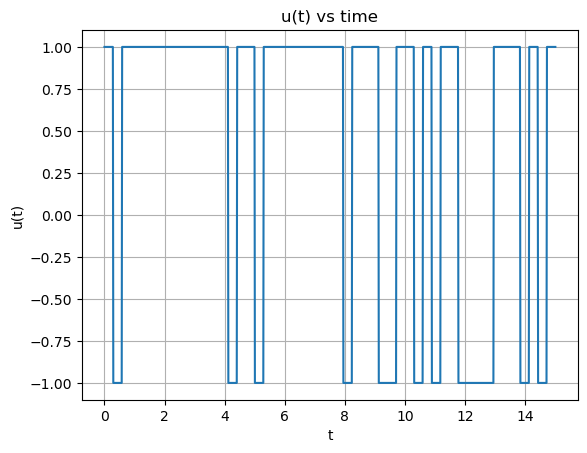

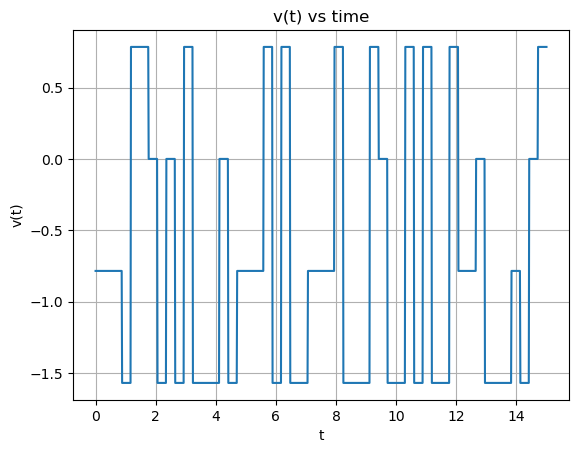

In [6]:
us=[2*(0.5-i%2) for i in u_t]
vs=[(1-i//2)*np.pi/4 for i in u_t]

u=[]
v=[]
for i in range(len(us)):
    for j in range(20):
        u.append(us[i])
        v.append(vs[i])
        
x = np.linspace(0, T, (N+1)*20)
plt.plot(x, u)
plt.xlabel('t')
plt.ylabel('u(t)')
plt.title("u(t) vs time")
plt.grid()
plt.show()

x = np.linspace(0, T, (N+1)*20)
plt.plot(x, v)
plt.xlabel('t')
plt.ylabel('v(t)')
plt.title("v(t) vs time")
plt.grid()
plt.show()

## Last Trajectory


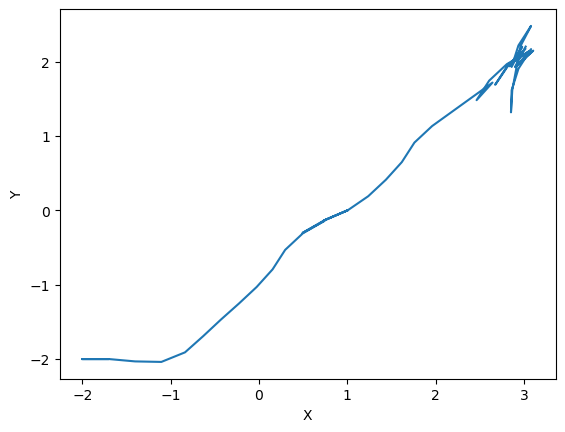

In [7]:
obs=np.array(observation_t)
obs=obs[:,[0,1]]
plt.plot(obs[:,0],obs[:,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

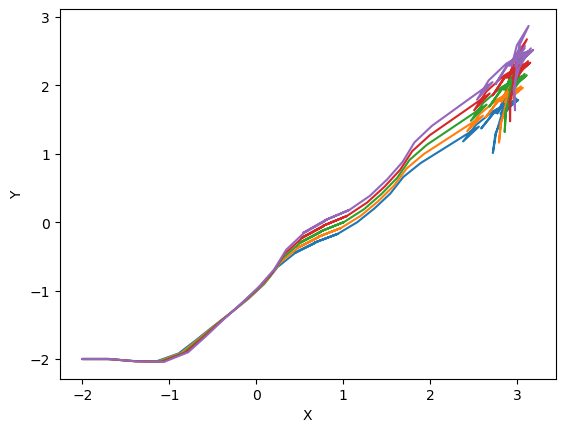

1.3712995191324366


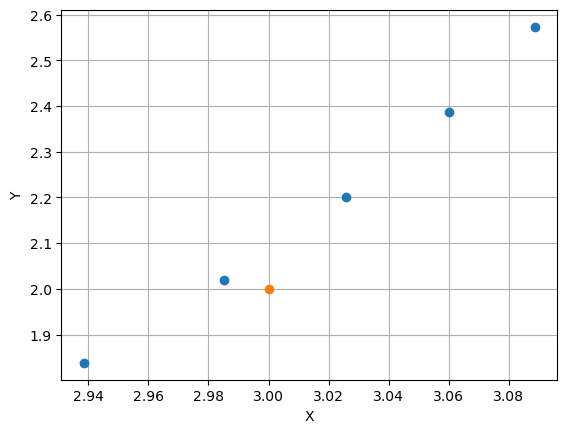

In [8]:
pos=[]
for i in range(num_system):
    obs=np.array(position_t[i])
    obs=obs[:,[0,1]]
    plt.plot(obs[:,0],obs[:,1])
    pos.append(obs[-1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
print(reward_raw(np.array(pos)))

cord_x=[]
cord_y=[]
for i in range(num_system):
    cord_x.append(pos[i][0])
    cord_y.append(pos[i][1])
plt.plot(np.array(cord_x),np.array(cord_y), 'o')
plt.plot(np.array([3]),np.array([2]), 'o')
#plt.plot(obs[-1,0],obs[-1,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.show()


## Best Trajectory

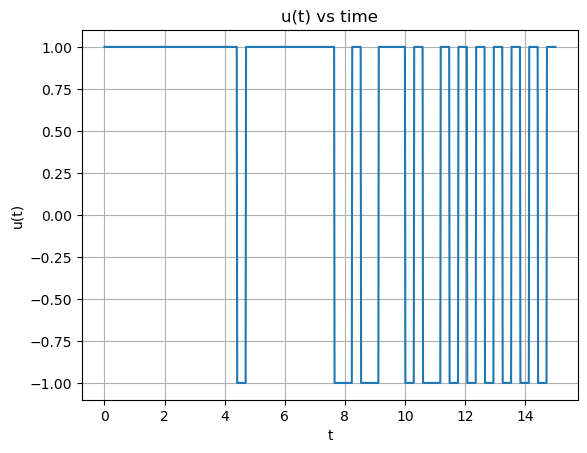

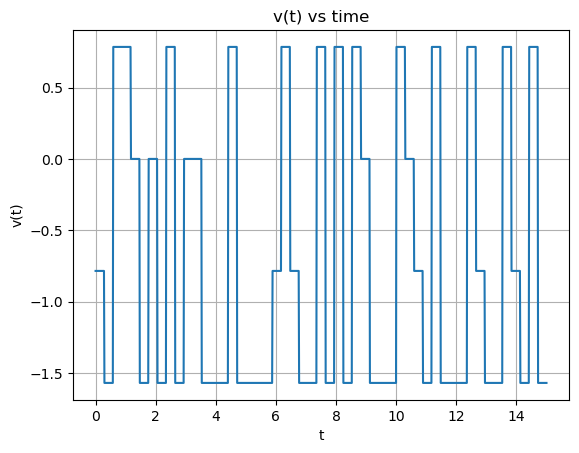

In [9]:
us=[2*(0.5-i%2) for i in best_u]
vs=[(1-i//2)*np.pi/4 for i in best_u]

u=[]
v=[]
for i in range(len(us)):
    for j in range(20):
        u.append(us[i])
        v.append(vs[i])

x = np.linspace(0, T, (N+1)*20)
plt.plot(x, u)
plt.xlabel('t')
plt.ylabel('u(t)')
plt.title("u(t) vs time")
plt.grid()
plt.show()

x = np.linspace(0, T, (N+1)*20)
plt.plot(x, v)
plt.xlabel('t')
plt.ylabel('v(t)')
plt.title("v(t) vs time")
plt.grid()
plt.show()

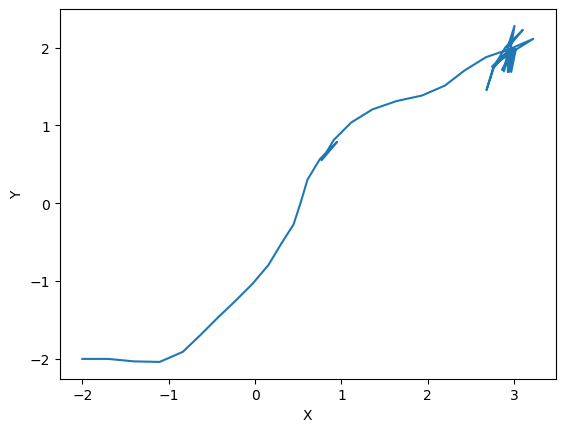

In [10]:
obs=np.array(best_obs)
obs=obs[:,[0,1]]
plt.plot(obs[:,0],obs[:,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

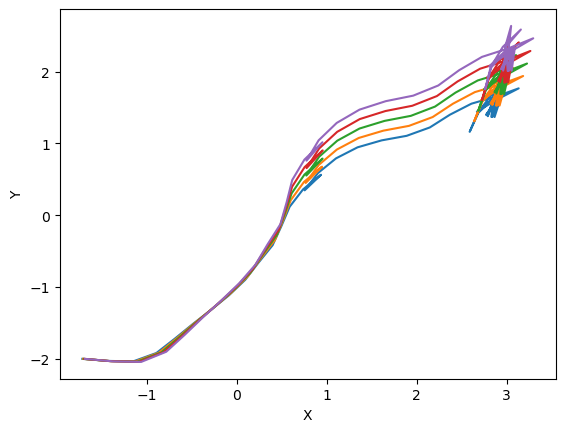

1.0682091637070272


In [11]:
pos=[]
for i in range(num_system):
    obs=np.array(best_pos[i])
    obs=obs[:,[0,1]]
    plt.plot(obs[:,0],obs[:,1])
    pos.append(obs[-1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
print(reward_raw(np.array(pos)))

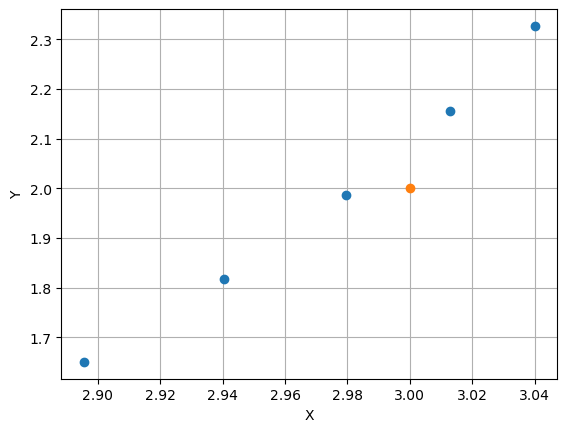

In [12]:
pos=[]
for i in range(num_system):
    obs=np.array(best_pos[i])
    obs=obs[:,[0,1]]
    #plt.plot(obs[:,0],obs[:,1])
    pos.append(obs[-1])

cord_x=[]
cord_y=[]
for i in range(num_system):
    cord_x.append(pos[i][0])
    cord_y.append(pos[i][1])
plt.plot(np.array(cord_x),np.array(cord_y), 'o')
plt.plot(np.array([3]),np.array([2]), 'o')
#plt.plot(obs[-1,0],obs[-1,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.show()

## Pure Exploitation Trajectory

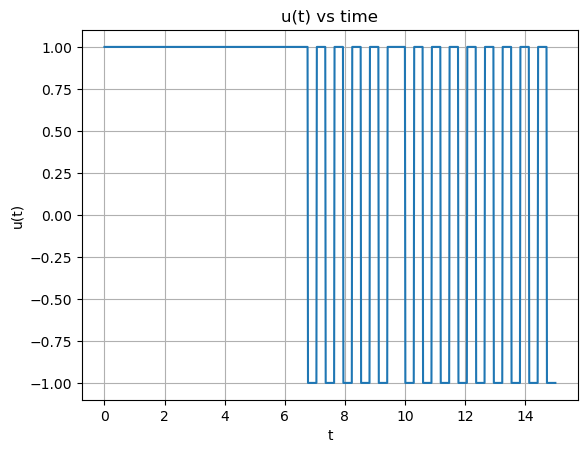

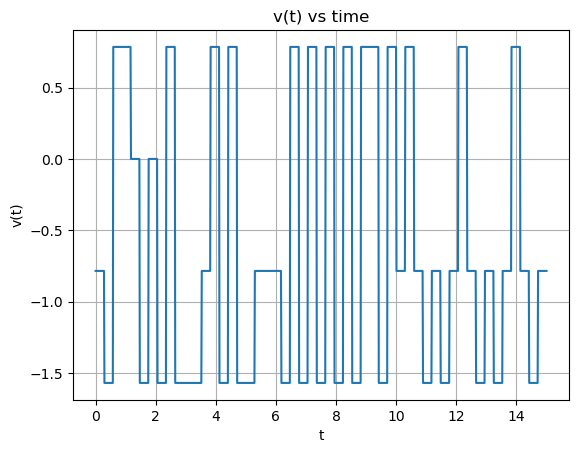

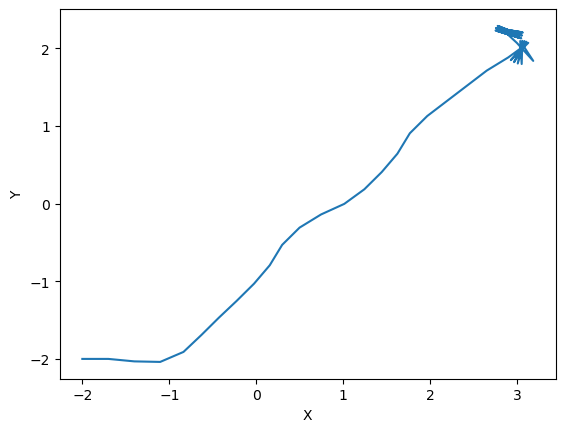

In [13]:
position=np.array([[-2,-2,0] for _ in range(num_system)])
observation=observe(position)
u_t=[]
observation_t=[observation]
position_t=[[] for i in range(num_system)]

for time in range(N+1):           
    
    #print(candidates_u)
    u_k = decide_u_exploitation(gpr_list[time],flags,observation)
    position_new = next_step(position,action_set[u_k])
    observation_new = observe(position_new)
    r = reward(observation_new)
    '''
    if explo:
        history_su[u_k] = np.concatenate((history_su[u_k], observation.reshape(-1,5)))
        history_r[u_k] = np.concatenate((history_r[u_k],np.array([r])))
    '''
    observation=observation_new
    position=position_new
    u_t.append(u_k)
    observation_t.append(observation)
    for i in range(num_system):
        position_t[i].append(position[i])
    '''
    if time%((N+1)//3+1)==0:
        for i in range(6):
            gpr_list[i]=GaussianProcessRegressor(alpha=1e-8).fit(history_su[i], history_r[i].reshape(-1,1))
    '''
    
us=[2*(0.5-i%2) for i in u_t]
vs=[(1-i//2)*np.pi/4 for i in u_t]

u=[]
v=[]
for i in range(len(us)):
    for j in range(20):
        u.append(us[i])
        v.append(vs[i])
    

x = np.linspace(0, T, (N+1)*20)
plt.plot(x, u)
plt.xlabel('t')
plt.ylabel('u(t)')
plt.title("u(t) vs time")
plt.grid()
plt.show()

x = np.linspace(0, T, (N+1)*20)
plt.plot(x, v)
plt.xlabel('t')
plt.ylabel('v(t)')
plt.title("v(t) vs time")
plt.grid()
plt.show()

obs=np.array(observation_t)
obs=obs[:,[0,1]]
plt.plot(obs[:,0],obs[:,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

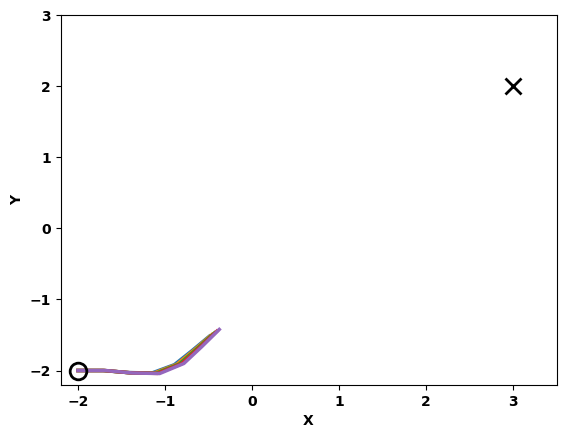

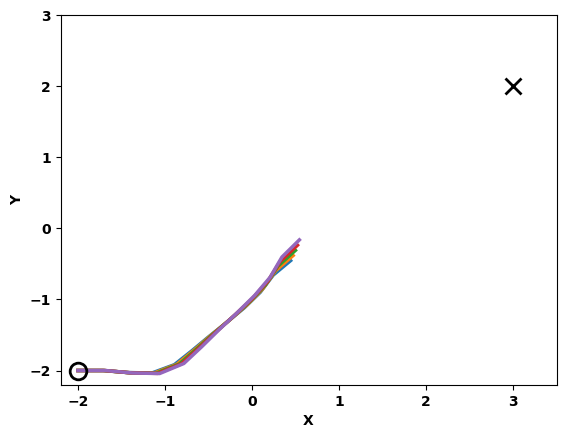

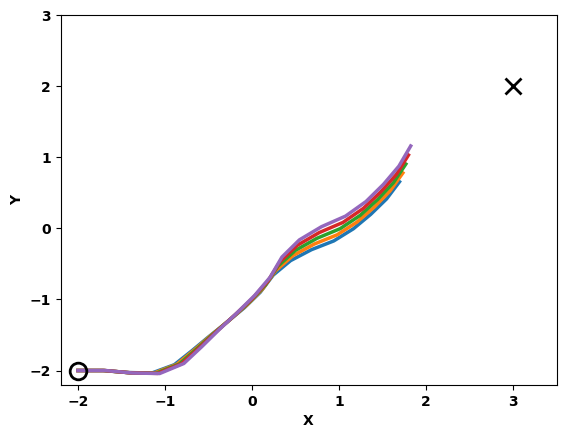

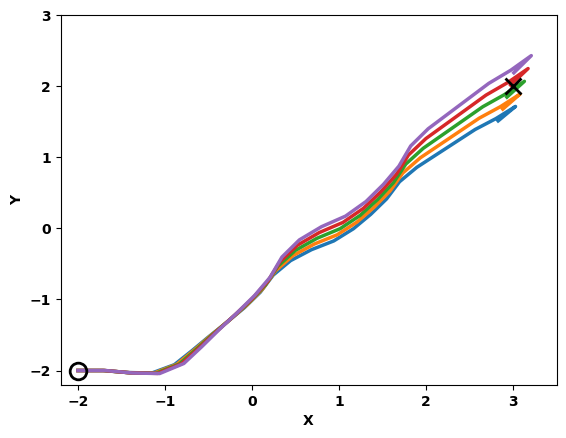

1.2860107730113963


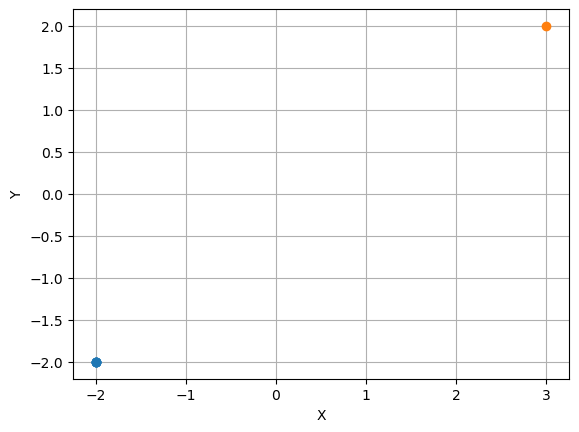

In [52]:
pos=[np.array([-2,-2,0]) for _ in range(num_system) ]
for i in range(num_system):
    obs=np.array(position_t[i])
    obs=obs[0:6,[0,1]]
    x=np.concatenate((np.array([-2]),obs[:6,0]))
    y=np.concatenate((np.array([-2]),obs[:6,1]))
    plt.plot(x,y,linewidth=2.5)
    pos.append(obs[-1])
plt.plot(np.array([-2]),np.array([-2]), 'o',color='black',markersize=12,markerfacecolor='none',markeredgewidth=2)
plt.plot(np.array([3]),np.array([2]), 'x',color='black',markersize=12,markeredgewidth=2)
plt.xlabel('X',fontweight="bold")
plt.ylabel('Y',fontweight="bold")
plt.xticks(weight="bold")
plt.yticks(weight="bold")
plt.xlim((-2.2, 3.5)) 
plt.ylim((-2.2, 3)) 
plt.show()

pos=[np.array([-2,-2,0]) for _ in range(num_system) ]
for i in range(num_system):
    obs=np.array(position_t[i])
    obs=obs[0:12,[0,1]]
    x=np.concatenate((np.array([-2]),obs[:11,0]))
    y=np.concatenate((np.array([-2]),obs[:11,1]))
    plt.plot(x,y,linewidth=2.5)
    pos.append(obs[-1])
plt.plot(np.array([-2]),np.array([-2]), 'o',color='black',markersize=12,markerfacecolor='none',markeredgewidth=2)
plt.plot(np.array([3]),np.array([2]), 'x',color='black',markersize=12,markeredgewidth=2)
plt.xlabel('X',fontweight="bold")
plt.ylabel('Y',fontweight="bold")
plt.xticks(weight="bold")
plt.yticks(weight="bold")
plt.xlim((-2.2, 3.5)) 
plt.ylim((-2.2, 3)) 
plt.show()

pos=[np.array([-2,-2,0]) for _ in range(num_system) ]
for i in range(num_system):
    obs=np.array(position_t[i])
    obs=obs[0:18,[0,1]]
    x=np.concatenate((np.array([-2]),obs[:17,0]))
    y=np.concatenate((np.array([-2]),obs[:17,1]))
    plt.plot(x,y,linewidth=2.5)
    pos.append(obs[-1])
plt.plot(np.array([-2]),np.array([-2]), 'o',color='black',markersize=12,markerfacecolor='none',markeredgewidth=2)
plt.plot(np.array([3]),np.array([2]), 'x',color='black',markersize=12,markeredgewidth=2)
plt.xlabel('X',fontweight="bold")
plt.ylabel('Y',fontweight="bold")
plt.xticks(weight="bold")
plt.yticks(weight="bold")
plt.xlim((-2.2, 3.5)) 
plt.ylim((-2.2, 3)) 
plt.show()

pos=[np.array([-2,-2,0]) for _ in range(num_system) ]
for i in range(num_system):
    obs=np.array(position_t[i])
    obs=obs[0:24,[0,1]]
    x=np.concatenate((np.array([-2]),obs[:25,0]))
    y=np.concatenate((np.array([-2]),obs[:25,1]))
    plt.plot(x,y,linewidth=2.5)
    pos.append(obs[-1])
plt.plot(np.array([-2]),np.array([-2]), 'o',color='black',markersize=12,markerfacecolor='none',markeredgewidth=2)
plt.plot(np.array([3]),np.array([2]), 'x',color='black',markersize=12,markeredgewidth=2)
plt.xlabel('X',fontweight="bold")
plt.ylabel('Y',fontweight="bold")
plt.xticks(weight="bold")
plt.yticks(weight="bold")
plt.xlim((-2.2, 3.5)) 
plt.ylim((-2.2, 3)) 
plt.show()
plt.show()
print(reward_raw(position))

cord_x=[]
cord_y=[]
for i in range(num_system):
    cord_x.append(pos[i][0])
    cord_y.append(pos[i][1])
plt.plot(np.array(cord_x),np.array(cord_y), 'o')
plt.plot(np.array([3]),np.array([2]), 'o')
#plt.plot(obs[-1,0],obs[-1,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.show()